In [9]:
import pandas as pd
import numpy as np
import datetime
import os
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import warnings
warnings.filterwarnings("ignore")

from scripts.charts import plot_line, plot_bar, plot_peak, print_charts_country
from scripts.features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

In [5]:
df_original_reports = pd.read_csv("data-processed/rki-reports.csv")
df_apple = pd.read_csv("data-processed/data_apple_prepared.csv")
df_rki_orig = pd.read_csv('dash/data/data_rki_apple_prepared_dash.csv')
df_jh_world = pd.read_csv('dash/data/data_jhu_world.csv')
# df = pd.read_csv("dash/data/data_rki_apple_prepared_dash.csv")
df_rki_orig['date']=df_rki_orig['date'].astype('datetime64[ns]')
df_rki_orig.index = df_rki_orig.date
df_jh_world['date']=df_jh_world['date'].astype('datetime64[ns]')
df_jh_world.index = df_jh_world.date

In [2]:
import plotly.graph_objects as go
import scipy as sp

def get_digit(s, place):
    s = "".join([i for i in str(s) if i.isdigit()]).lstrip("0")
    if len(s) >= place:
        return s[place - 1]
    else:
        return -1
    
COLORS = {'paper_bgcolor': 'LightGray',
          'plot_bgcolor': 'LightGray',
          'xaxis': 'LightSteelBlue',
          'yaxis': 'LightSteelBlue',
          'font': 'DarkBlue',
          'elem1': 'DarkBlue',
          'elem2': 'white',
          'elem3': 'DarkGrey',
          'elem4': 'DarkGrey',
         }    
COLORS = {'paper_bgcolor': 'white',
          'plot_bgcolor': 'white',
          'xaxis': 'LightSteelBlue',
          'yaxis': 'LightSteelBlue',
          'font': 'Black',
          'elem1': 'LightGray',
          'elem2': 'Black',
          'elem3': 'Black',
          'elem4': 'DarkBlue',
         }    
    
def bar(df, column , digit, df_benford, land):
    d1 = df.loc[df[f'{digit}digit'] != -1, :]
    obs = len(d1)
    
    d1_c = d1.groupby(by=f'{digit}digit').count().loc[:, [column]]
    d1_c.columns = ['cnt']
    d1 = (d1.groupby(by=f'{digit}digit').count() / d1[f'{digit}digit'].count() * 100).loc[:, [column]].round(1)
    d1 = d1.join(df_benford, how='outer')
    d1 = d1.join(d1_c, how='outer')

    d1[f'ben{digit}'] = d1[f'ben{digit}']/100
    d1[column] = d1[column]/100

    def std(row):
        return (row[f'ben{digit}'] * (1 - row[f'ben{digit}']) / row.cnt)**0.5

    def zscore(row):
        return abs((abs(row[column] - row[f'ben{digit}']) - (1 / row.cnt * 2)) / row.s)

    d1['s'] = d1.apply(lambda r: std(r), axis=1)
    d1['z'] = d1.apply(lambda r: zscore(r), axis=1)

    d1['p'] = np.round(sp.stats.norm.pdf(np.abs(d1['z'])),2)
    
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
#     fig = go.Figure()

    # ACTUAL VALUES
#     fig.add_trace(go.Scatter(
#         mode='lines',
#         line=dict(
#              color=COLORS['elem1'],
#              width=5
#          ),
#         x=d1.index,
#         y=d1[column],
#         name=f'{digit} place digit',
#         marker_color=COLORS['elem1']))
    fig.add_trace(go.Bar(
            x=d1.index,
            y=d1[column],
            width=[0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,],
        marker=dict(color=COLORS['font'],
# #                      opacity=0.8
                        line=dict(width=1)
                     ),
            name=f'Actual, {digit} digit',
            marker_color=COLORS['elem1']))
    
    # BENFORD'S LAW
    fig.add_trace(go.Scatter(
        mode='lines+markers',
        line=dict(
             color=COLORS['elem2'],
             width=1,
#              dash='dot', 
         ),
        x=d1.index,
        y=d1[f'ben{digit}'],
        name="Benford's Law",
        marker_color=COLORS['elem2']))
    
#     fig.add_trace(go.Indicator(
#         mode='number',
#         title='Correlation',
#         value=d1.loc[:, [column, f'ben{digit}']].corr().iloc[0,1].round(2)*100))
    
    # 0.05 P-Value
    fig.add_shape(
            # Line Diagonal
                type="line",
                x0=0,
                y0=0.05,
                x1=9,
                y1=0.05,
                line=dict(
                    color=COLORS['elem3'],
                    width=1,
                    dash="dot",
                ), 
                yref="y2"
                        )
    # p-value
#     fig.add_trace(go.Bar(
#         x=d1.index,
#         y=d1['p'],
#         width=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],
#         name=f'p-value',
#         marker=dict(color=COLORS['elem4'],
# #                      opacity=0.8
# #                         line=dict(width=1)
#                      ),
#         ),
#         secondary_y=True)
    fig.add_trace(go.Scatter(
            mode="markers",
            x=d1.index,
            y=d1['p'],
            name=f'p-value',
            marker=dict(color=COLORS['elem4'],
    #                      opacity=0.8
    #                         line=dict(width=1)
                         ),
            ),
            secondary_y=True)
    
    
    fig.update_layout(
        margin=dict(l=0, r=0, t=35, b=0),
        autosize=False,
        width=800,
        height=250, 
        paper_bgcolor=COLORS['paper_bgcolor'], 
        plot_bgcolor=COLORS['plot_bgcolor'],  # '#1f2630'
        title=f"{land}: {' '.join([x.capitalize() for x in column.split('_')])}, digit position {digit}",
#         barmode='group',
#         xaxis_title= f"{' '.join([x.capitalize() for x in column.split('_')])}, digit position {digit}",
        yaxis_title='Frequency',
        xaxis_title='Number',
        yaxis2_title='p-value',
        xaxis=dict(
            linecolor=COLORS['xaxis'],
            showgrid=False,
            dtick=1), 
        yaxis=dict(showgrid=False,linecolor=COLORS['yaxis']),
        font=dict(color=COLORS['font'], family='Garmond'), # '#2cfec1'
#         yaxis2=dict(showgrid=False, range=[0, 0.2])
                    )
    
#     print('Observations: ', obs)
#     print("Correlation: ", f"{d1.loc[:, [column, f'ben{digit}']].corr().iloc[0,1].round(2)*100}%")
    fig.show()
    
def plot_benford(df, land, column = 'dead_change'):
    df2 = df.loc[(df.land == land) & (df[column] > 0), [column]].dropna().astype(int)
    
    ben1 = pd.DataFrame(data=[30.1 ,17.6 ,12.5	,9.7 ,7.9 ,6.7 ,5.8	,5.1 ,4.6], index = [str(x) for x in range(1,10)], columns=['ben1'])
    ben2 = pd.DataFrame(data=[12.0,	11.4, 10.9,	10.4, 10.0,	9.7, 9.3, 9.0, 8.8, 8.5], index = [str(x) for x in range(0,10)], columns=['ben2'])

    df2['1digit'] = df2[column].apply(lambda x: get_digit(x, 1)) 
    df2['2digit'] = df2[column].apply(lambda x: get_digit(x, 2)) 

    bar(df2, column, 1, ben1, land)

    bar(df2, column, 2, ben2, land)


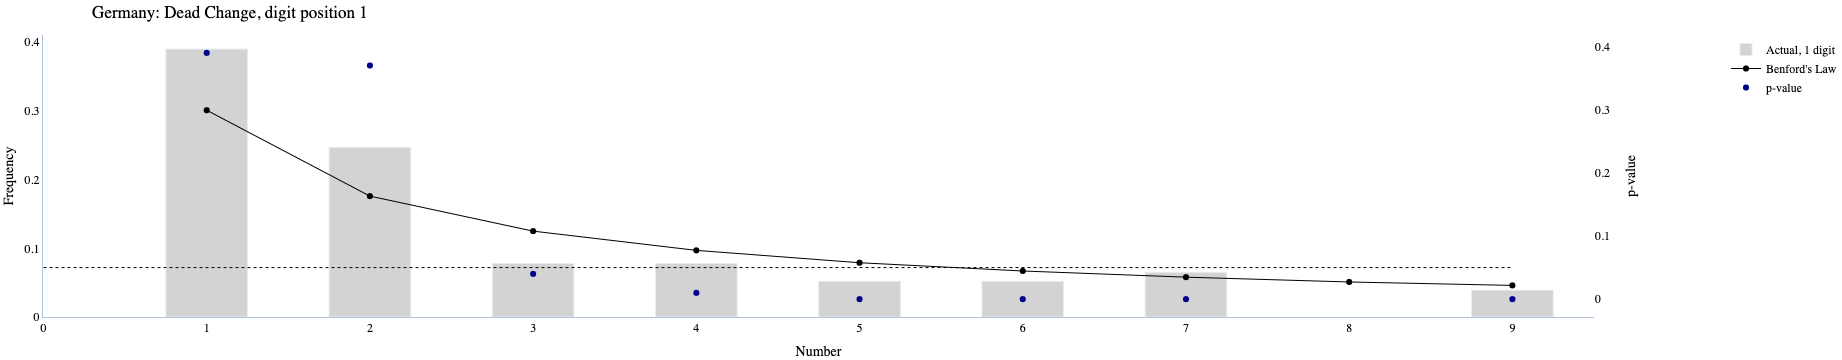

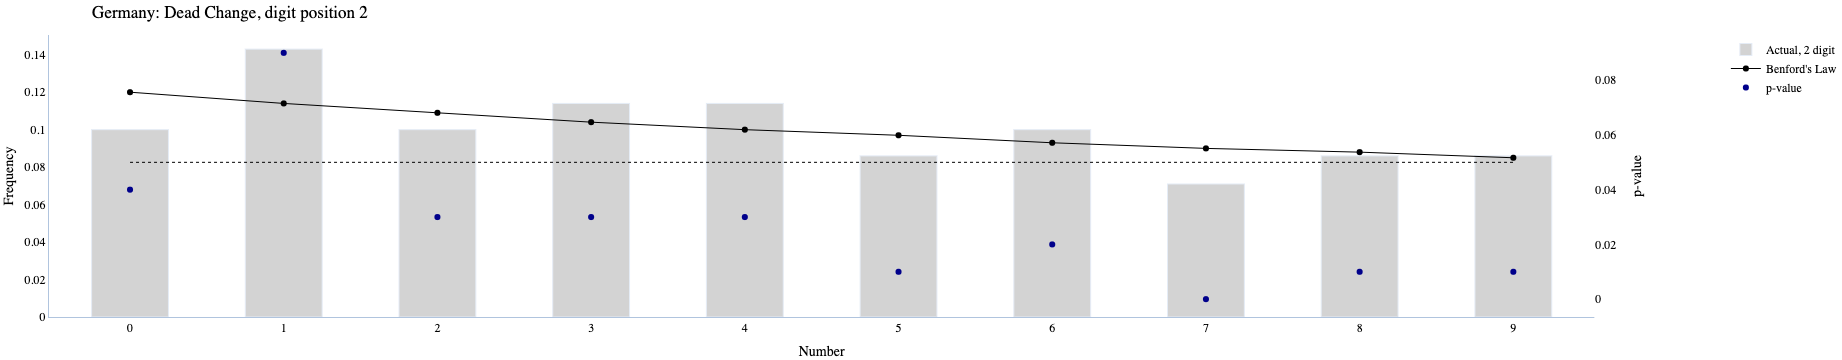

In [8]:
plot_benford(df_jh_world, "Germany", 'dead_change')

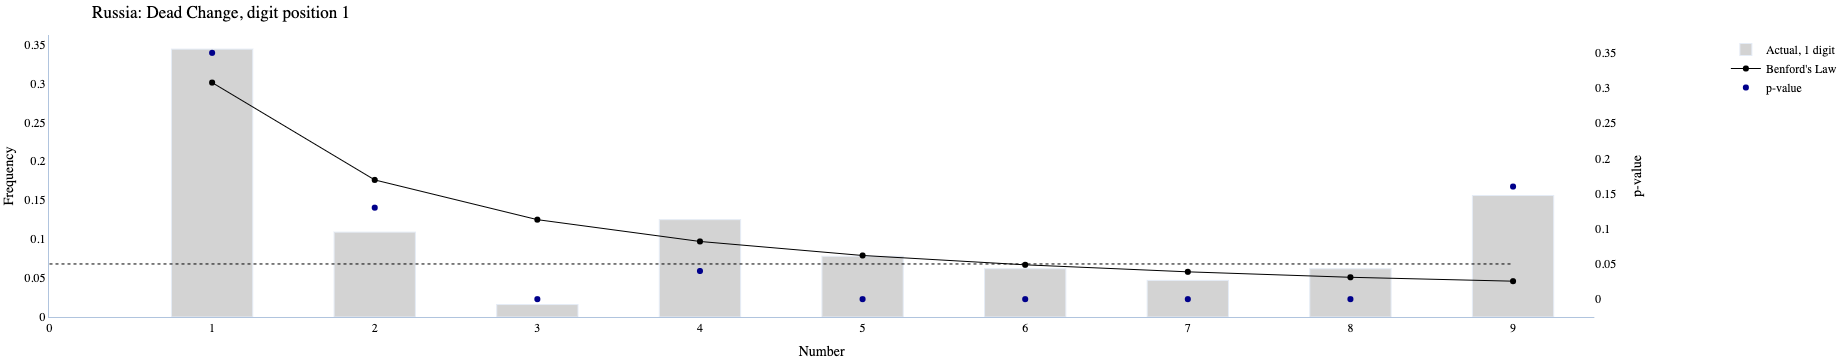

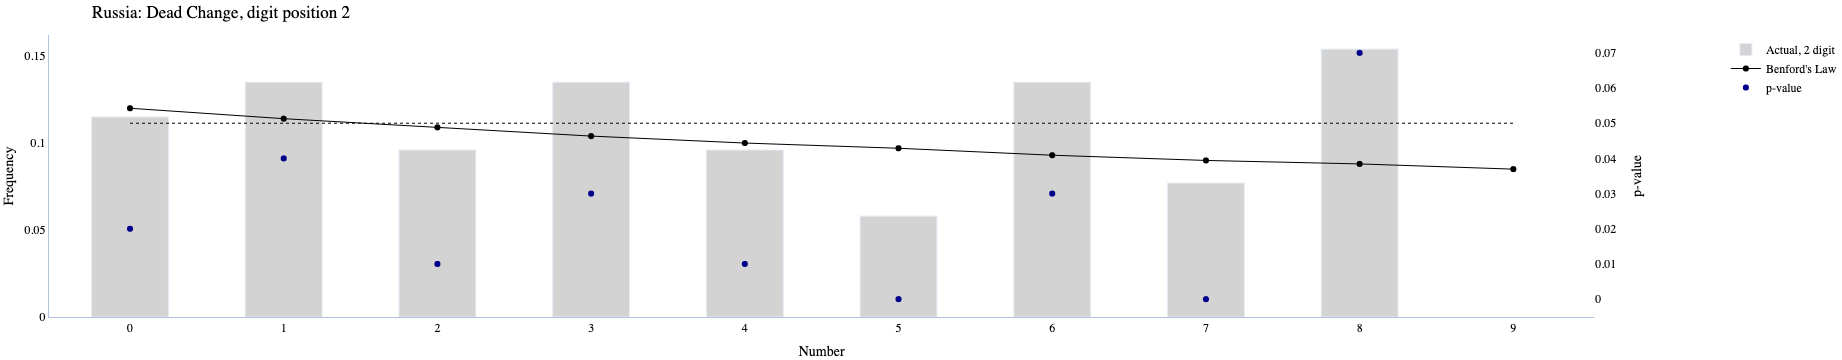

In [7]:
plot_benford(df_jh_world, "Russia", 'dead_change')